In [1]:
import pandas as pd
import numpy as np

%pylab inline

Populating the interactive namespace from numpy and matplotlib


How many taxi trips are reported in the original file?

In [2]:
%%sh
wc -l yellow_tripdata_2016-12.csv 

wc: yellow_tripdata_2016-12.csv: Нет такого файла или каталога


Getting random samples:

In [ ]:
%%sh
head -n 1 yellow_tripdata_2016-12.csv > sample100.csv
tail -n +2 yellow_tripdata_2016-12.csv | gshuf -n 100 | sed 's/,,//g' >> sample100.csv

In [20]:
sample100 = pd.read_csv('sample100.csv', parse_dates=[1,2])
sample100.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount
0,2,2016-12-15 12:18:37,2016-12-15 12:28:45,6,0.50,1,N,141,237,2,7.5,0.0,0.5,0.00,0.00,0.3,8.30
1,1,2016-12-20 22:39:23,2016-12-20 22:50:27,1,2.00,1,N,246,164,1,9.5,0.5,0.5,3.00,0.00,0.3,13.80
2,1,2016-12-09 23:02:06,2016-12-09 23:11:03,1,1.10,1,N,114,79,1,7.5,0.5,0.5,1.75,0.00,0.3,10.55
3,1,2016-12-11 15:40:19,2016-12-11 16:09:53,1,11.90,1,N,138,224,1,34.0,0.0,0.5,8.05,5.54,0.3,48.39
4,2,2016-12-19 11:34:28,2016-12-19 11:47:51,1,1.96,1,N,261,144,2,10.5,0.0,0.5,0.00,0.00,0.3,11.30


## Estimating the proportion of tippers

In [5]:
is_tipped = sample100.tip_amount>0
is_tipped.mean()

0.66000000000000003

Standard deviation:

In [6]:
ph = is_tipped.mean()
s = np.sqrt(ph * (1-ph) / len(is_tipped))
s

0.047370877129308042

95% confidence interval:

In [7]:
from statsmodels.stats.proportion import proportion_confint
proportion_confint(sum(is_tipped), len(is_tipped), alpha=0.05)

(0.56715478691048404, 0.75284521308951602)

Pretty wide! How big do we need a sample for the 95% confidence interval to be approximately 2% wide?

In [68]:
from statsmodels.stats.proportion import samplesize_confint_proportion
int(np.ceil(samplesize_confint_proportion(ph, 0.01)))

8789

Let's take a bigger sample:

In [9]:
%%sh
head -n 1 yellow_tripdata_2016-12.csv > sample10000.csv
tail -n +2 yellow_tripdata_2016-12.csv | gshuf -n 10000 | sed 's/,,//g' >> sample10000.csv

head: невозможно открыть 'yellow_tripdata_2016-12.csv' для чтения: Нет такого файла или каталога
sh: 2: gshuf: not found
tail: невозможно открыть 'yellow_tripdata_2016-12.csv' для чтения: Нет такого файла или каталога


In [35]:
sample10000 = pd.read_csv('sample10000.csv', parse_dates=[1,2])
is_tipped = sample10000.tip_amount>0
is_tipped.mean()

0.61209999999999998

Using the data dictionary, check how many passengers in the sample paid for their ride with cash.

In [48]:
cachers = sample10000[sample10000['payment_type'] == 2]
cachers.shape[0]
sample10000.payment_type.value_counts()

3543

In [72]:
cachers = sample10000.payment_type == 2
from statsmodels.stats.proportion import proportion_confint
conf = proportion_confint(sum(cachers), len(cachers), alpha=0.01)
round(conf[0], 4)

0.342

Use the same sample to estimate the average trip distance in miles. Provide the answer with at least two digits after decimal.

In [58]:
round(sample10000.trip_distance.mean(), 2)

2.88

What is the standard deviation of the estimator from the previous question? Provide the answer with at least three digits after decimal.

In [59]:
ph = cachers.mean()
s = np.sqrt(ph * (1-ph) / len(cachers))
round(s, 3)

0.005

In [77]:
trip_dist = sample10000.trip_distance < sample10000.trip_distance.mean()
conf = proportion_confint(sum(trip_dist), len(trip_dist), alpha=0.05)
print (conf)
round(conf[1], 2)

(0.72301589721994819, 0.74038410278005184)


0.74

---

In [12]:
ph = is_tipped.mean()
s = np.sqrt(ph * (1-ph) / len(is_tipped))
s

0.047370877129308042

In [39]:
proportion_confint(sum(is_tipped), len(is_tipped), alpha=0.05)

(0.60254965257891324, 0.62165034742108671)

It is indeed about 2% wide. 

## Estimating the average trip duration

In [14]:
sample100['duration'] = [x.total_seconds() / 60 for x in sample100.tpep_dropoff_datetime -  sample100.tpep_pickup_datetime]

In [15]:
sample100['duration'].mean() 

14.145500000000006

In [16]:
s = sample100['duration'].std(ddof=1) / np.sqrt(len(sample100['duration']))
s

1.2435186819673423

In [17]:
from statsmodels.stats.weightstats import _tconfint_generic
_tconfint_generic(sample100['duration'].mean(), 
                  s, 
                  len(sample100['duration']) - 1, 
                  0.05, 'two-sided')

(11.67808915172267, 16.612910848277341)

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f9c090a6990>]], dtype=object)

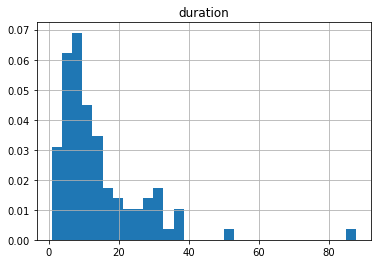

In [18]:
sample100.hist(column = 'duration', bins=30, normed=True)

In [19]:
sample10000['duration'] = [x.total_seconds() / 60 for x in sample10000.tpep_dropoff_datetime -  sample10000.tpep_pickup_datetime]

NameError: name 'sample10000' is not defined

In [ ]:
sample10000['duration'].mean()

In [ ]:
s = sample10000['duration'].std(ddof=1) / np.sqrt(len(sample10000['duration']))
s

In [ ]:
_tconfint_generic(sample10000['duration'].mean(), 
                  s, 
                  len(sample10000['duration']) - 1, 
                  0.05, 'two-sided')

In [ ]:
sample10000.hist(column = 'duration', bins=30, normed=True)

In [ ]:
tmp = sample10000['duration'] < 120
tmp.value_counts()

In [ ]:
sample10000[sample10000['duration'] < 120].hist(column = 'duration', bins=30, normed=True)
sample10000['duration'][sample10000['duration'] < 120].mean()

In [ ]:
sample100['duration'].median()

In [ ]:
sample10000['duration'].median()

In [ ]:
sample10000['duration'][sample10000['duration'] < 120].median()

Bootstrap:

In [ ]:
def get_bootstrap_samples(data, n_samples):
    indices = np.random.randint(0, len(data), (n_samples, len(data)))
    samples = data[indices]
    return samples
    
def stat_intervals(stat, alpha):
    boundaries = np.percentile(stat, [100 * alpha / 2., 100 * (1 - alpha / 2.)])
    return boundaries

In [ ]:
median_duration = list(map(np.median, get_bootstrap_samples(sample100['duration'].values, 1000)))
stat_intervals(median_duration, 0.05)

In [ ]:
median_duration = list(map(np.median, get_bootstrap_samples(sample10000['duration'].values, 1000)))
stat_intervals(median_duration, 0.05)